In [1]:
import sys
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary
from torchviz import make_dot

import matplotlib.pyplot as plt

from model import NeuralNet, RecurrentNet, ConvNet

from utils import *

In [2]:
model_name = "CNN"
training_data = "allGR"
test_dir = "./allGR"
n_feature = 11
seq_length = 100
hidden_dim = 32
n_layer = 4
r_drop = 0.5
nn_output = "merger_flag"

loss = "weighted_bce"
batch_size = 128
epoch = 100
lr = 0.001

output_dir = f"./output/{nn_output}_nf{n_feature}_seq{seq_length}"
model_base = f"{model_name}_{training_data}_{nn_output}_nf{n_feature}_sl{seq_length}_hd{hidden_dim}_nl{n_layer}_r{r_drop}_{loss}_bs{batch_size}_ep{epoch}_lr{lr}"
model_dir = f"{output_dir}/{model_base}"

# Load model

In [3]:
if model_name == "NN":
    model = NeuralNet(n_input=n_feature, hidden_dim=hidden_dim, n_layer=n_layer, r_drop=r_drop)
elif model_name == "RNN":
    model = RecurrentNet(input_dim=n_feature, hidden_dim=hidden_dim, n_layer=n_layer)
elif model_name == "CNN":
    model = ConvNet(input_dim=n_feature, seq_length=seq_length, hidden_dim=hidden_dim, n_layer=n_layer)
else:
    print("Error: unkonwn model", file=sys.stderr)
    sys.exit(1)

In [4]:
fmodel = "{}/model.pth".format(model_dir)
model.load_state_dict(torch.load(fmodel))
model.eval()

ConvNet(
  (blocks): ModuleList(
    (0): Conv1dBlock(
      (conv): Conv1d(11, 32, kernel_size=(5,), stride=(2,), padding=(2,))
      (drop): Dropout(p=0, inplace=False)
      (act): LeakyReLU(negative_slope=0.01)
    )
    (1): Conv1dBlock(
      (conv): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
      (drop): Dropout(p=0, inplace=False)
      (act): LeakyReLU(negative_slope=0.01)
    )
    (2): Conv1dBlock(
      (conv): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (drop): Dropout(p=0, inplace=False)
      (act): LeakyReLU(negative_slope=0.01)
    )
    (3): Conv1dBlock(
      (conv): Conv1d(128, 256, kernel_size=(5,), stride=(2,), padding=(2,))
      (drop): Dropout(p=0, inplace=False)
      (act): LeakyReLU(negative_slope=0.01)
    )
  )
  (linear): Linear(in_features=1792, out_features=1, bias=True)
  (output_act): Sigmoid()
)

In [5]:
summary(model, input_size=(batch_size, seq_length, n_feature), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ConvNet                                  --                        --                        --
├─ModuleList: 1-1                        --                        --                        --
│    └─Conv1dBlock: 2-1                  [128, 11, 100]            [128, 32, 50]             --
│    │    └─Conv1d: 3-1                  [128, 11, 100]            [128, 32, 50]             1,792
│    │    └─Dropout: 3-2                 [128, 32, 50]             [128, 32, 50]             --
│    │    └─LeakyReLU: 3-3               [128, 32, 50]             [128, 32, 50]             --
│    └─Conv1dBlock: 2-2                  [128, 32, 50]             [128, 64, 25]             --
│    │    └─Conv1d: 3-4                  [128, 32, 50]             [128, 64, 25]             10,304
│    │    └─Dropout: 3-5                 [128, 64, 25]             [128, 64, 25]             --
│    │    └─LeakyReLU: 3-6  

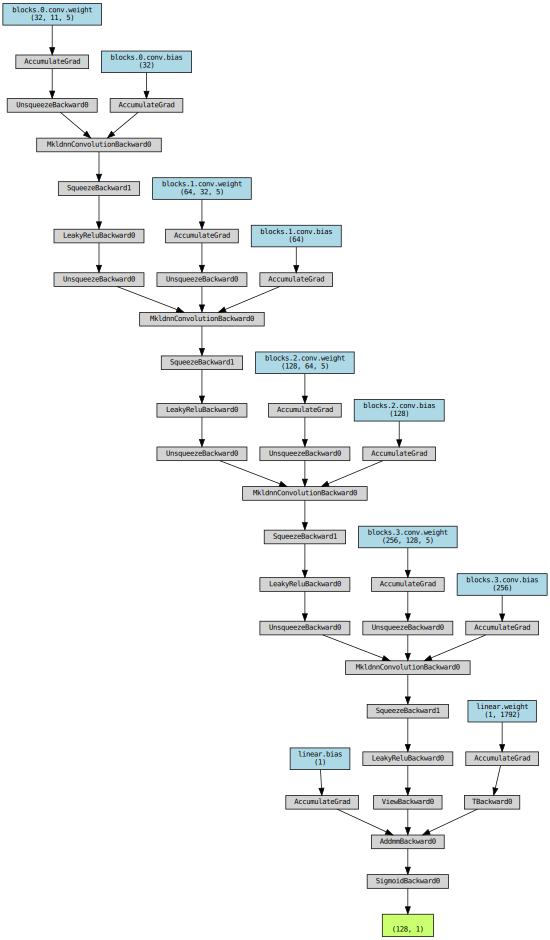

In [6]:
data = torch.randn(batch_size, seq_length, n_feature)
y = model(data)

image = make_dot(y, params=dict(model.named_parameters()))
image.format = "png"
image.render(f"{model_dir}/vis")

image

# Show weights

In [7]:
if model_name == "CNN":
    print(model.blocks[0].conv.weight)
    for i in range(n_layer):
        print(f"weights in conv {i}:", model.blocks[i].conv.weight.size())

Parameter containing:
tensor([[[-0.1056,  0.1334,  0.1320, -0.0054,  0.0361],
         [-0.0724,  0.0403, -0.0127,  0.1073,  0.0410],
         [-0.0123, -0.0409, -0.0837,  0.1084,  0.0216],
         ...,
         [ 0.0168, -0.0062,  0.1184,  0.1542,  0.0929],
         [-0.0543, -0.0847, -0.0565,  0.0430,  0.0187],
         [-0.0223,  0.1023,  0.1091,  0.1063, -0.0029]],

        [[ 0.0912,  0.0910, -0.0154,  0.0860,  0.0974],
         [ 0.0101, -0.0898,  0.0251,  0.0242, -0.0738],
         [-0.0882,  0.1193, -0.0897,  0.0566,  0.0791],
         ...,
         [-0.0551,  0.0198, -0.0937, -0.1131,  0.0730],
         [-0.1323,  0.0931,  0.1190, -0.0063, -0.1133],
         [ 0.1508,  0.0744,  0.0105, -0.0951,  0.1543]],

        [[ 0.0987, -0.0191,  0.0181, -0.1283, -0.1066],
         [-0.0258,  0.0676, -0.0656, -0.0310,  0.0157],
         [ 0.0186,  0.0819, -0.0961, -0.1249, -0.1016],
         ...,
         [ 0.0557, -0.1237,  0.0218,  0.1227, -0.1300],
         [-0.1293,  0.0624, -0.0691,

# Load test data

In [8]:
norm_params = np.loadtxt("{}/norm_params_seq{}_nf{}.txt".format(test_dir, seq_length, n_feature))
test_fnames = [ "{}/toct{:d}_secular_{:d}.hdf5".format(test_dir, i, j) 
                for i in range(56, 58) for j in range(40, 141)]
data, label = load_data(test_fnames, seq_length=seq_length, n_feature=n_feature, output_model=nn_output, norm_params=norm_params)
output = model(data)

# output mode: merger_flag
# data size: torch.Size([200, 100, 11])
# label size: torch.Size([200, 1])


# Saliency analysis

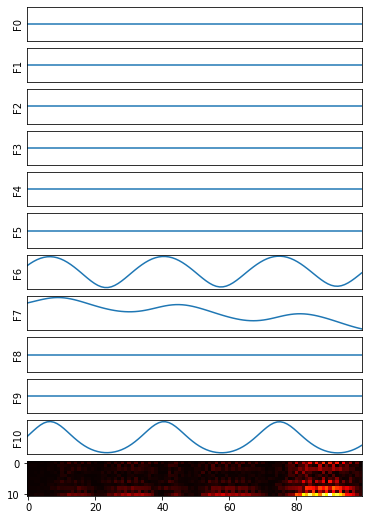

In [35]:
X = data[0]
X = torch.unsqueeze(X, 0)
X.requires_grad_()
Y = model(X)
Y = Y.squeeze()
Y.backward()
saliency = X.grad.data.abs()
saliency = saliency[0] #(seq_length, n_feqture)

fig, ax = plt.subplots(n_feature+1,1, figsize=(6,9))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
X_ = X.cpu().detach().numpy()
t = [ a for a in range(seq_length) ]
for i in range(n_feature):
    ax[i].set_xlim([t[0],t[-1]])
    ax[i].plot(t, X_[0,:,i])
    #ax[i].set_title(f"feature {i}")#, fontsize=10)
    ax[i].set_ylabel(f"F{i}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[n_feature].imshow(saliency.cpu().transpose(0,1), cmap="hot", aspect="auto")
plt.show()